# Statistics of Missing Data

In [11]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob, re
import pickle
from scipy.stats import pearsonr
from tqdm import tqdm
import numba as nb

In [9]:
filenames = sorted(glob.glob('uk-smart-meter-data/LCL-June2015v2_*.csv'))
# sort numerically rather than lexicographic
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))

In [2]:
data = pd.DataFrame()
batch = 4 

# match batch: 
#     case 1:
#         for idx in range(0,50):
#             data = pd.concat([data, pd.read_csv(filenames[idx])])
#         data.to_pickle('preprocessed_dfs/data_batch1.pkl')
#     case 2:
#         for idx in range(50,100):
#             data = pd.concat([data, pd.read_csv(filenames[idx])])
#         data.to_pickle('preprocessed_dfs/data_batch2.pkl')
#     case 3:
#         for idx in range(100,150):
#             print(idx)
#             data = pd.concat([data, pd.read_csv(filenames[idx])])
#         data.to_pickle('preprocessed_dfs/data_batch3.pkl')
#     case 4: 
#         for idx in range(150,168):
#             data = pd.concat([data, pd.read_csv(filenames[idx])])
#         data.to_pickle('preprocessed_dfs/data_batch4.pkl')


# to check if the number of ids do not coincide between batches
# match batch: 
#     case 1:
#         for idx in range(0,50):
#             data = pd.concat([data, pd.read_csv(filenames[idx], usecols = [0])])
#         data.to_pickle('preprocessed_dfs/data_batch1_cols.pkl')
#     case 2:
#         for idx in range(50,100):
#             data = pd.concat([data, pd.read_csv(filenames[idx], usecols = [0])])
#         data.to_pickle('preprocessed_dfs/data_batch2_cols.pkl')
#     case 3:
#         for idx in range(100,150):
#             data = pd.concat([data, pd.read_csv(filenames[idx], usecols = [0])])
#         data.to_pickle('preprocessed_dfs/data_batch3_cols.pkl')
#     case 4: 
#         for idx in range(150,168):
#             data = pd.concat([data, pd.read_csv(filenames[idx], usecols = [0])])
#         data.to_pickle('preprocessed_dfs/data_batch4_cols.pkl')


NameError: name 'filenames' is not defined

In [3]:
file = open('preprocessed_dfs/data_batch4.pkl', 'rb')
data = pickle.load(file)


In [12]:
data

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC002534,ToU,2012-09-23 03:30:00.0000000,0.095
1,MAC002534,ToU,2012-09-23 04:00:00.0000000,0.095
2,MAC002534,ToU,2012-09-23 04:30:00.0000000,0.094
3,MAC002534,ToU,2012-09-23 05:00:00.0000000,0.083
4,MAC002534,ToU,2012-09-23 05:30:00.0000000,0.086
...,...,...,...,...
932469,MAC005565,ToU,2012-06-21 05:30:00.0000000,1.022
932470,MAC005565,ToU,2012-06-21 06:00:00.0000000,0.188
932471,MAC005565,ToU,2012-06-21 06:30:00.0000000,0.073
932472,MAC005565,ToU,2012-06-21 07:00:00.0000000,0.025


## Some preprocessing

### Dropping duplicates and 'stdorToU' column 

In [13]:
df = data.copy()

# transform data to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

# dropping the stdorToU column for convenience
df = df.drop(columns=['stdorToU'])

# dropping duplicates
# Counter number of duplicates
print('Number of duplicates: ', df.duplicated(subset=['DateTime', 'LCLid']).sum())
df_unique = df.drop_duplicates(subset=['DateTime', 'LCLid'], keep='last').copy()

# Counter number of duplicates
print('Number of duplicates: ', df_unique.duplicated(subset=['DateTime', 'LCLid']).sum())

Number of duplicates:  12348
Number of duplicates:  0


### Rename the LCLids with only numbers

MAC000002 >> 2

In [14]:
#df_unique.loc[:,'LCLid'] = df_unique['LCLid'].apply(lambda x: int(re.sub('\D', '', x)))
df_unique['LCLid'] = df_unique['LCLid'].str.replace(r'\D', '', regex=True).astype(int)

#### Sort the data according to LCLids

In [7]:
df_unique.sort_values(by=['LCLid'], inplace = True)


### Resample data for 30 mins (strictly)
Observation from excel: The "Null" values were corresponding to non-30 minute sample. So, aggregating the data for strictly 30 minute sample

In [10]:
pivoted = df_unique.pivot(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ').copy()
pivoted_resampled = pivoted.resample('1h').sum()
#pivoted_resampled.to_csv('resampled_batch4.csv')
#pearsonr(pivoted_resampled.iloc[:,0], pivoted_resampled.iloc[:, 1])[0]

### Making Graph - Batch 4

In [8]:
df_graph = pivoted_resampled.copy()

NameError: name 'pivoted_resampled' is not defined

In [7]:
df_graph

NameError: name 'df_graph' is not defined

In [51]:
@nb.jit(nopython = True)
def calculate_similarity(df):
    """
    df: 
        Index: DateTime
        Columns: LCLid
    """
    cols = df_graph.shape[1]
    similarity_matrix = np.zeros((cols, cols))
    for i in tqdm(range(cols-1)):
        for j in range(cols-1):
            similarity = pearsonr(df_graph.iloc[:,i], df_graph.iloc[:,j])[0]
            similarity_matrix[i,j] = similarity
            similarity_matrix[j,i] = similarity
    return similarity_matrix
    
similarity_matrix = calculate_similarity(df_graph)

In [52]:
# np.save('graph_data/similarity_matrix',similarity_matrix)
# df_sm = pd.DataFrame(similarity_matrix)
# df_sm.columns = df_graph.columns
# df_sm.index = df_graph.columns
# df_sm.to_csv('graph_data/df_sim_matrix.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [17:23<00:00,  1.70s/it]


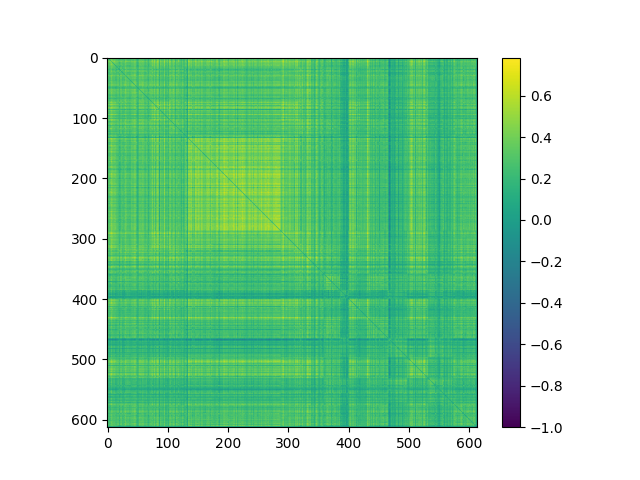

In [24]:
sim_matrix = np.load('graph_data/similarity_matrix.npy')
fig, ax = plt.subplots()
pos = ax.imshow(sim_matrix - np.eye(sim_matrix.shape[0]))
fig.colorbar(pos, ax = ax)
plt.show()

### Load the window data

In [10]:
file = open('preprocessed_dfs/batch_4_durations.pkl', 'rb')
df_b4 = pickle.load(file)
df_b4['LCLid'] = df_b4['LCLid'].apply(lambda x: int(re.sub('\D', '', x)))
df_b4

,LCLid,Enabled At,Disabled At,Duration
0,2534,2012-09-23 03:30:00,2014-02-28 00:00:00,522 days 20:30:00
1,2536,2012-07-09 10:30:00,2014-02-28 00:00:00,598 days 13:30:00
2,2552,2012-07-09 12:00:00,2014-02-28 00:00:00,598 days 12:00:00
3,2560,2012-07-09 13:00:00,2014-02-28 00:00:00,598 days 11:00:00
4,2566,2012-07-09 13:30:00,2014-02-28 00:00:00,598 days 10:30:00
...,...,...,...,...
608,5550,2012-04-18 09:00:00,2014-02-28 00:00:00,680 days 15:00:00
609,5551,2012-04-18 08:30:00,2014-02-28 00:00:00,680 days 15:30:00
610,5557,2012-09-28 10:30:00,2014-02-28 00:00:00,517 days 13:30:00
611,5564,2012-07-17 10:00:00,2014-02-28 00:00:00,590 days 14:00:00


In [ ]:
file = open('preprocessed_dfs/data_batch1_cols.pkl')

####